<a href="https://colab.research.google.com/github/ashbyj/applied-modeling-techniques/blob/main/multiple-linear-regression/diamondRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of this analysis will be to predict diamond prices in usd using various regression techniques.
I will use the cliche Kaggle diamond dataset: https://www.kaggle.com/datasets/shivam2503/diamonds.
However, this will be a fresh analysis and not a copy of any tutorial or other published notebook.


I started by getting the set into a DataFrame and checking for duplicate IDs.

In [12]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

drive.mount('/content/drive/')
path_to_csv = '/content/drive/MyDrive/ColabNotebooks/diamonds.csv'

df = pd.read_csv(path_to_csv)
print(df.head())

df = df.rename(columns={'Unnamed: 0': 'id'})
if df['id'].is_unique:
  print('no duplicates found')

print(df.head())

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
   Unnamed: 0  carat      cut color clarity  depth  table  price     x     y  \
0           1   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98   
1           2   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84   
2           3   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07   
3           4   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23   
4           5   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35   

      z  
0  2.43  
1  2.31  
2  2.31  
3  2.63  
4  2.75  
no duplicates found
   id  carat      cut color clarity  depth  table  price     x     y     z
0   1   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   2   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   3   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   4   

I then checked each column for nulls and found none.  Given that regression techniques usually require numerical data, the 3 categorical columns also needed special handling.  I started this by eyeballing the distribution of values in those columns and found nothing that would raise any flags here.  

id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64
Figure(432x288)


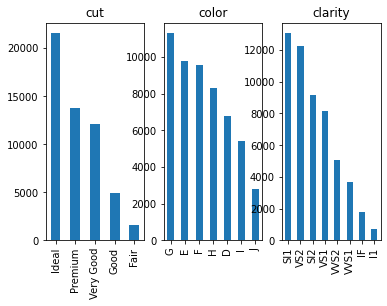

In [21]:
print(df.isna().sum())
categorical_columns = ['cut','color','clarity']

fig, ax = plt.subplots(1, len(categorical_columns))
print(fig)
print(ax)
for i, column in enumerate(df[categorical_columns]):
  df[column].value_counts().plot(kind='bar', ax=ax[i]).set_title(column)
  
fig.show()


Although there are only a few variables here, the 3 categorical variables will need to be converted to dummy variables and this model should be as accurate as possible, while also being explainable.  If variables can be removed, they should be.  The first step will be to look at multicollinearity.  

https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/#:~:text=Multicollinearity%20occurs%20when%20two%20or,variable%20in%20a%20regression%20model.

In [22]:
# dummies!! drop first to maintain the independence assumption
df = pd.get_dummies(df, drop_first=True)
df.corr().abs()

,id,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
id,1.000000,0.377983,0.034800,0.100830,0.306873,0.405440,0.395843,0.399208,0.044601,0.108812,...,0.065322,0.043354,0.051648,0.078778,0.050275,0.160590,0.026121,0.030002,0.094045,0.090003
carat,0.377983,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387,0.034196,0.163660,...,0.102465,0.161494,0.180054,0.114449,0.062669,0.267483,0.063094,0.038904,0.167571,0.137024
depth,0.034800,0.028224,1.000000,0.295779,0.010647,0.025289,0.029341,0.094924,0.136114,0.022778,...,0.026037,0.022630,0.022543,0.030881,0.040899,0.007202,0.024169,0.009459,0.023477,0.019243
table,0.100830,0.181618,0.295779,1.000000,0.127134,0.195344,0.183760,0.150929,0.175174,0.549599,...,0.011574,0.017967,0.037253,0.078766,0.051959,0.095344,0.026858,0.009655,0.069103,0.062273
price,0.306873,0.921591,0.010647,0.127134,1.000000,0.884435,0.865421,0.861249,0.000312,0.097175,...,0.059223,0.097125,0.081710,0.049596,0.008957,0.128420,0.009886,0.001062,0.095266,0.052381
x,0.405440,0.975094,0.025289,0.195344,0.884435,1.000000,0.974701,0.970772,0.030349,0.162674,...,0.095896,0.146522,0.164658,0.125976,0.079241,0.270827,0.059882,0.035507,0.185253,0.147151
y,0.395843,0.951722,0.029341,0.183760,0.865421,0.974701,1.000000,0.952006,0.032187,0.153158,...,0.093480,0.142895,0.160776,0.120800,0.076097,0.263252,0.056490,0.035928,0.179271,0.141624
z,0.399208,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000,0.045169,0.158688,...,0.095041,0.145276,0.164217,0.125248,0.081005,0.263192,0.058513,0.036314,0.182401,0.144746
cut_Good,0.044601,0.034196,0.136114,0.175174,0.000312,0.030349,0.032187,0.045169,1.000000,0.258018,...,0.009517,0.006187,0.014977,0.033046,0.055938,0.041970,0.017116,0.021063,0.037564,0.038627
cut_Ideal,0.108812,0.163660,0.022778,0.549599,0.097175,0.162674,0.153158,0.158688,0.258018,1.000000,...,0.021264,0.009225,0.038490,0.104986,0.082865,0.108242,0.034247,0.015669,0.088354,0.075508


There are certainly some high correlations between independent variables here, but it would be nice to have an empirical way of ranking the correlations to know which are acceptable.  For now, I will go with the rule of thumb > 5 is worth investigating and 10 is highly correlated.

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

drop_price = df.drop(['id','price'], axis = 1)

high_vif_column = []
max_vif = 11

while max_vif >= 10:
  vif_data = pd.DataFrame()
  vif_data['feature'] = drop_price.columns

  vif_data['vif'] = [variance_inflation_factor(drop_price.values, i) 
                     for i in range(len(drop_price.columns))]
  max_vif = max(vif_data['vif'])
  if max_vif > 10:
    max_loc = vif_data.loc[vif_data['vif'] == max_vif]
    max_vif_feature = max_loc['feature'].values[0]
    high_vif_column.append(max_vif_feature)
    drop_price = drop_price.drop(max_vif_feature, axis=1)

print('dropped columns with vifs > 10: ', high_vif_column)
print('current vif scores:')
print(vif_data)
df = df.drop(high_vif_column, axis=1)
df.head()


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


dropped columns with vifs > 10:  ['x', 'depth', 'y', 'z', 'table', 'cut_Ideal']
current vif scores:
          feature       vif
0           carat  4.648915
1        cut_Good  1.229661
2     cut_Premium  1.644957
3   cut_Very Good  1.538428
4         color_E  2.320527
5         color_F  2.316121
6         color_G  2.637482
7         color_H  2.211607
8         color_I  1.852052
9         color_J  1.479537
10     clarity_IF  1.274871
11    clarity_SI1  3.109927
12    clarity_SI2  2.794975
13    clarity_VS1  2.307734
14    clarity_VS2  2.874504
15   clarity_VVS1  1.540888
16   clarity_VVS2  1.736418


,id,carat,price,cut_Good,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,1,0.23,326,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,2,0.21,326,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,3,0.23,327,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3,4,0.29,334,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,5,0.31,335,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


Its not surprising to see that the size columns, x, y, depth and table were removed as hightly correleated with the other values.  These will all be replaced with carat.  I do question if these could have been combined into a single variable 'size'.  i will explore this later.  No other features had a vif over 5, so this is our final feature set.  

I will need to check for all 4 of the linear regression assumptions.  

https://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/R/R5_Correlation-Regression/R5_Correlation-Regression4.html

- Independence: Observations are independent of each other.
- Linearity: The relationship between X and the mean of Y is linear.
- Homoscedasticity: The variance of residual is the same for any value of X.
- Normality: For any fixed value of X, Y is normally distributed.

Independence is an easy one to check off, each observation here is likely a discrete diamond as each row had unique IDs.  Linearity will be next.